In [298]:
import pandas as pd
pitch_symbol = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

df = pd.read_csv("songs.csv")
df.columns

Index(['Unnamed: 0', 'key', 'tags', 'duration', 'liveness', 'valence',
       'artist_genres', 'mode', 'danceability', 'artist_names',
       ...
       'B_90', 'B_91', 'B_92', 'B_93', 'B_94', 'B_95', 'B_96', 'B_97', 'B_98',
       'B_99'],
      dtype='object', length=1241)

In [299]:
df.iloc[:,:25]

,Unnamed: 0,key,tags,duration,liveness,valence,artist_genres,mode,danceability,artist_names,...,instrumentalness,time_signature,C_max,C_min,C#_max,C#_min,D_max,D_min,D#_max,D#_min
0,005lwxGU1tms6HGELIcUv9,5.0,"['i killed a bird and i lyked it', 'dancing so...",179640,0.1320,0.696,"['dance pop', 'pop']",1.0,0.699,['Katy Perry'],...,0.000000,4.0,1.0,0.019,1.0,0.013,1.0,0.013,1.0,0.015
1,00B7TZ0Xawar6NZ00JFomN,9.0,"['rap', 'hip-hop', 'underground hip-hop', 'chi...",284855,0.3140,0.665,"['chicago rap', 'hip hop', 'pop', 'rap', 'danc...",1.0,0.620,"['Chance the Rapper', 'Cardi B']",...,0.000000,4.0,1.0,0.015,1.0,0.011,1.0,0.019,1.0,0.011
2,00GOPLxW4PGQuUYdPJh8K1,1.0,"['psychedelic hip-hop', 'childish gambino', 'h...",180675,0.6430,0.581,"['atl hip hop', 'rap', 'hip hop']",0.0,0.710,['Childish Gambino'],...,0.000000,4.0,1.0,0.002,1.0,0.005,1.0,0.002,1.0,0.002
3,00Mb3DuaIH1kjrwOku9CGU,0.0,"['skate punk', 'Energetic', 'canada', 'bubbleg...",204000,0.3580,0.484,"['canadian pop', 'pop', 'dance pop', 'candy po...",1.0,0.487,['Avril Lavigne'],...,0.000000,4.0,1.0,0.024,1.0,0.018,1.0,0.012,1.0,0.005
4,00R0fEFZGb5hyTgF1nrRCq,0.0,"['california', 'west coast hip hop', 'hip hop'...",248810,0.6800,0.681,"['hip pop', 'hip hop', 'rap', 'east coast hip ...",1.0,0.600,"['Kendrick Lamar', 'Busta Rhymes']",...,0.000000,4.0,1.0,0.013,1.0,0.012,1.0,0.012,1.0,0.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3686,7zMcNqs55Mxer82bvZFkpg,10.0,"['2000s', 'KDWB', 'female vocalists', 'country...",203040,0.1190,0.289,['pop'],1.0,0.621,['Taylor Swift'],...,0.000000,4.0,1.0,0.002,1.0,0.001,1.0,0.002,1.0,0.001
3687,7zQcq1UIdlplwkoTuJcU1r,0.0,"['party', 'brit pop', 'boyband', 'House', '201...",215204,0.0881,0.428,"['boy band', 'pop', 'edm', 'pop rock', 'dance ...",0.0,0.730,['The Wanted'],...,0.000004,4.0,1.0,0.019,1.0,0.008,1.0,0.011,1.0,0.004
3688,7zRmGvtSy36Jr19U5OInJT,1.0,"['classic rock', '60s', 'british', 'pop', 'rock']",158800,0.5430,0.788,"['classic rock', 'psychedelic rock', 'rock', '...",1.0,0.660,['The Beatles'],...,0.000000,4.0,1.0,0.013,1.0,0.018,1.0,0.004,1.0,0.004
3689,7zSbZj5aalmS4yYLOLwDd6,2.0,"['reggae', 'rnb', 'rap', 'dancehall', 'hip-hop']",212493,0.1010,0.382,"['pop', 'moombahton', 'tropical house', 'elect...",1.0,0.700,"['Sean Paul', 'Major Lazer']",...,0.000000,4.0,1.0,0.010,1.0,0.008,1.0,0.002,1.0,0.003


/tmp/ipykernel_31512/3455874424.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.iloc[:,:17].corr(), annot=True)


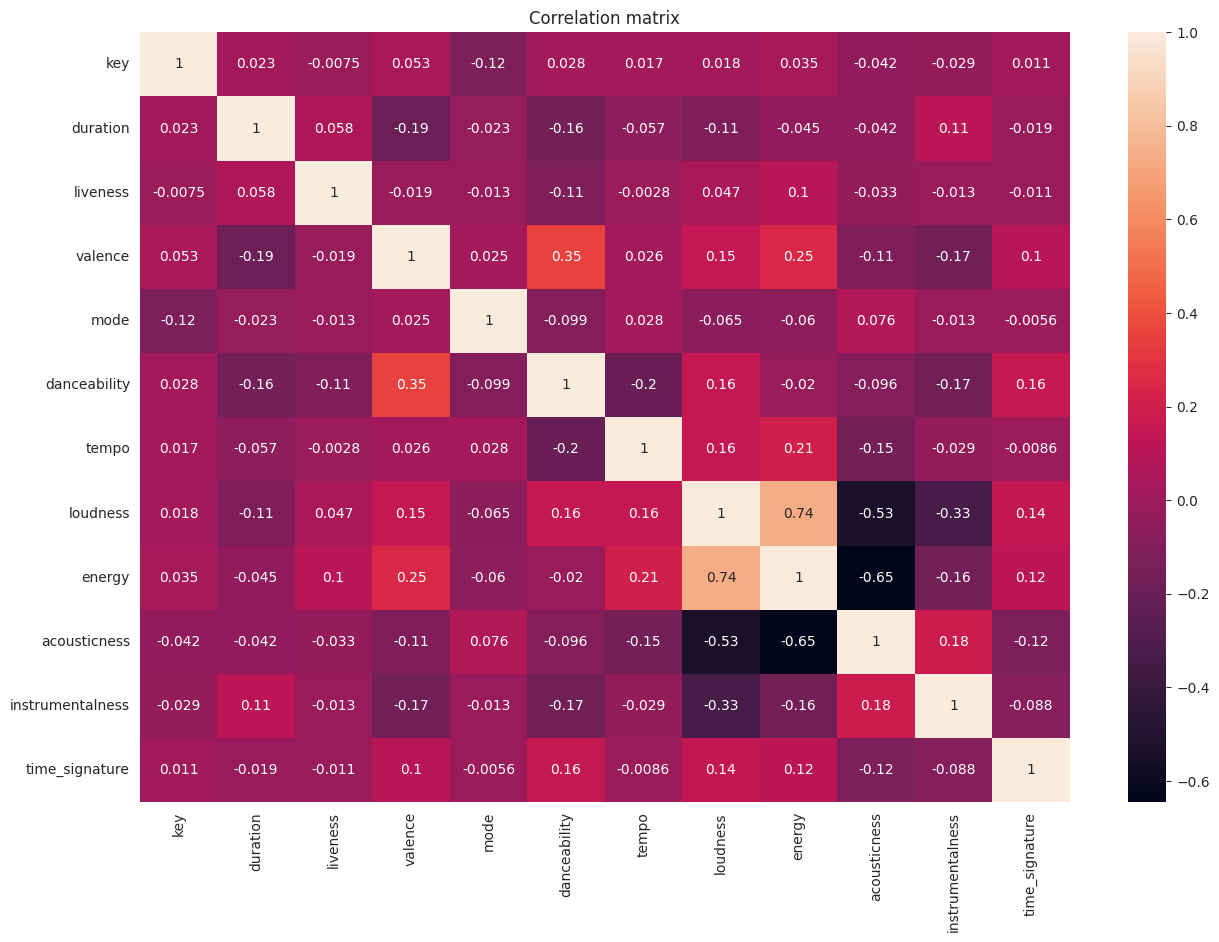

In [300]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,10))
sns.heatmap(df.iloc[:,:17].corr(), annot=True)
plt.title("Correlation matrix")
plt.show()

In [301]:
df

,Unnamed: 0,key,tags,duration,liveness,valence,artist_genres,mode,danceability,artist_names,...,B_90,B_91,B_92,B_93,B_94,B_95,B_96,B_97,B_98,B_99
0,005lwxGU1tms6HGELIcUv9,5.0,"['i killed a bird and i lyked it', 'dancing so...",179640,0.1320,0.696,"['dance pop', 'pop']",1.0,0.699,['Katy Perry'],...,0.423800,0.358250,0.325286,0.302333,0.143286,0.361429,0.526833,0.350286,0.201286,0.284500
1,00B7TZ0Xawar6NZ00JFomN,9.0,"['rap', 'hip-hop', 'underground hip-hop', 'chi...",284855,0.3140,0.665,"['chicago rap', 'hip hop', 'pop', 'rap', 'danc...",1.0,0.620,"['Chance the Rapper', 'Cardi B']",...,0.109167,0.360357,0.459800,0.359000,0.406364,0.682875,0.467000,0.664700,0.579636,0.709000
2,00GOPLxW4PGQuUYdPJh8K1,1.0,"['psychedelic hip-hop', 'childish gambino', 'h...",180675,0.6430,0.581,"['atl hip hop', 'rap', 'hip hop']",0.0,0.710,['Childish Gambino'],...,0.247000,0.885750,0.278500,0.457000,0.340429,0.424167,0.507143,0.414750,0.427375,0.439667
3,00Mb3DuaIH1kjrwOku9CGU,0.0,"['skate punk', 'Energetic', 'canada', 'bubbleg...",204000,0.3580,0.484,"['canadian pop', 'pop', 'dance pop', 'candy po...",1.0,0.487,['Avril Lavigne'],...,0.258800,0.337375,0.378429,0.198333,0.112000,0.380600,0.701250,0.322400,0.225250,0.044500
4,00R0fEFZGb5hyTgF1nrRCq,0.0,"['california', 'west coast hip hop', 'hip hop'...",248810,0.6800,0.681,"['hip pop', 'hip hop', 'rap', 'east coast hip ...",1.0,0.600,"['Kendrick Lamar', 'Busta Rhymes']",...,0.230333,0.278400,0.158778,0.255900,0.260917,0.230545,0.284077,0.431111,0.211375,0.401667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3686,7zMcNqs55Mxer82bvZFkpg,10.0,"['2000s', 'KDWB', 'female vocalists', 'country...",203040,0.1190,0.289,['pop'],1.0,0.621,['Taylor Swift'],...,0.069200,0.366400,0.042400,0.104833,0.040333,0.056000,0.351000,0.326667,0.371333,0.741667
3687,7zQcq1UIdlplwkoTuJcU1r,0.0,"['party', 'brit pop', 'boyband', 'House', '201...",215204,0.0881,0.428,"['boy band', 'pop', 'edm', 'pop rock', 'dance ...",0.0,0.730,['The Wanted'],...,0.479800,0.429556,0.157125,0.324200,0.493091,0.315182,0.294556,0.341444,0.535333,0.181333
3688,7zRmGvtSy36Jr19U5OInJT,1.0,"['classic rock', '60s', 'british', 'pop', 'rock']",158800,0.5430,0.788,"['classic rock', 'psychedelic rock', 'rock', '...",1.0,0.660,['The Beatles'],...,0.199000,0.180600,0.304800,0.248250,0.237400,0.226800,0.279500,0.292200,0.529800,0.230500
3689,7zSbZj5aalmS4yYLOLwDd6,2.0,"['reggae', 'rnb', 'rap', 'dancehall', 'hip-hop']",212493,0.1010,0.382,"['pop', 'moombahton', 'tropical house', 'elect...",1.0,0.700,"['Sean Paul', 'Major Lazer']",...,0.020000,0.302250,0.032429,0.104778,0.080125,0.095800,0.158111,0.094778,0.178556,0.072333


In [302]:
df = df[df["tags"].notna()]

In [303]:
rock_df = cur_data = df[df["tags"].str.contains("Rock")]

/tmp/ipykernel_31512/17480920.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(rock_df.iloc[:,:17].corr(), annot=True)


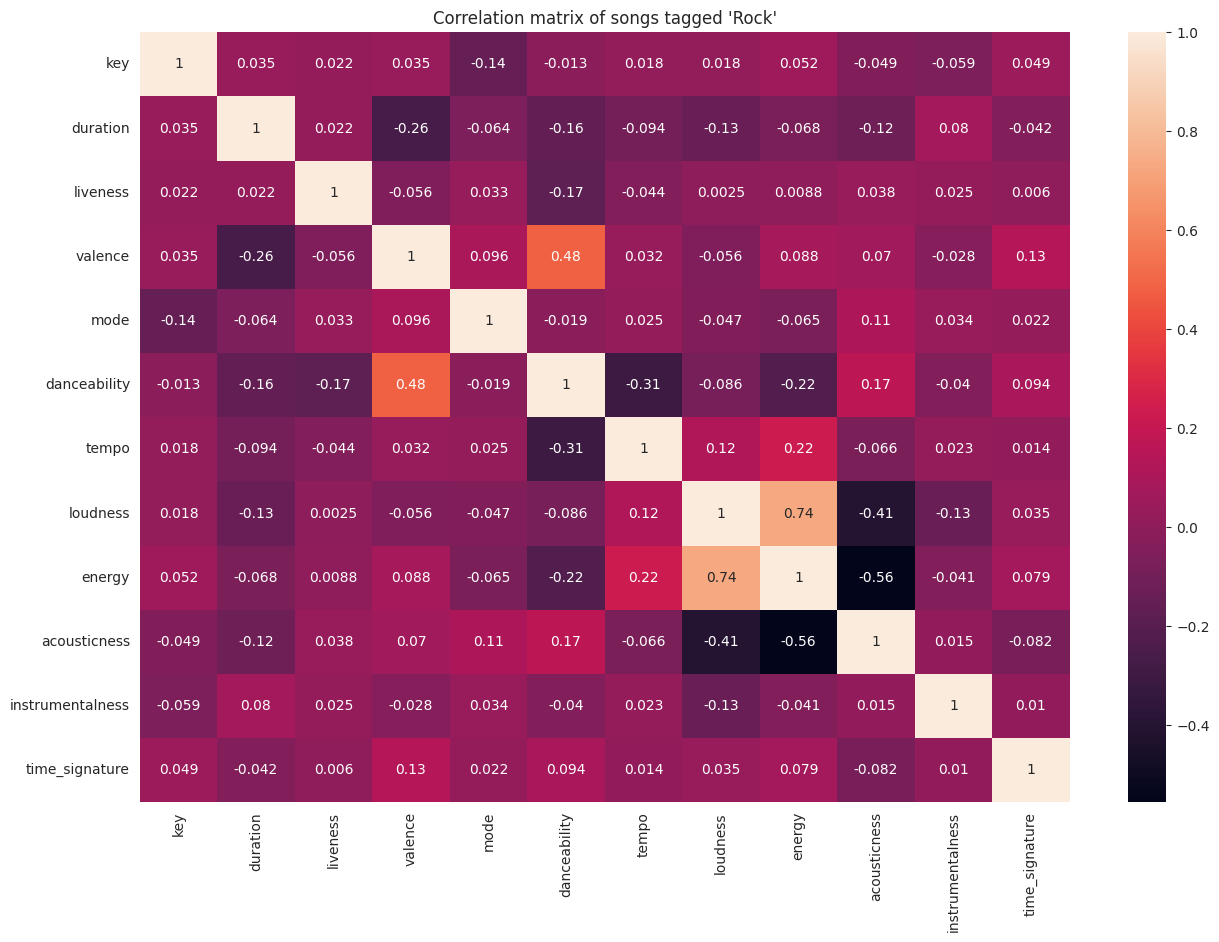

In [304]:
plt.figure(figsize=(15,10))
sns.heatmap(rock_df.iloc[:,:17].corr(), annot=True)
plt.title("Correlation matrix of songs tagged 'Rock'")
plt.show()

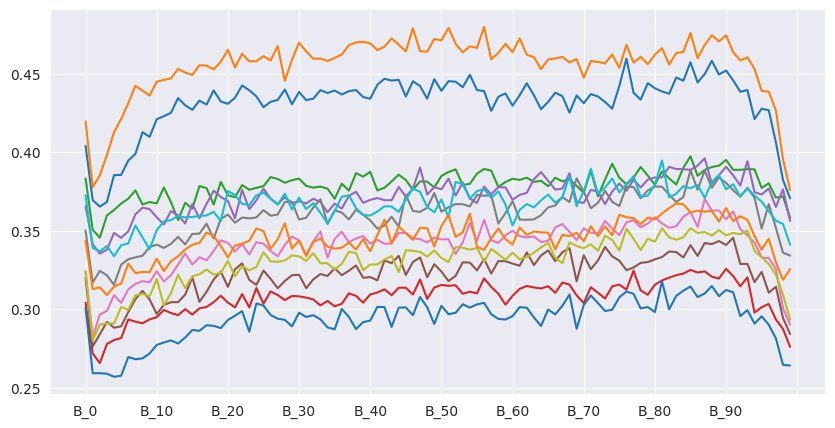

In [305]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xticks(range(0, 101, 10))
#ax.set_xticklabels([i for i in range(0, 101, 10)])
for i, note in enumerate(pitch_symbol):
    #cur_ax.set_title(note)
    curr_df = rock_df[[*[note + "_" + str(i) for i in range(0, 100)]]].mean().transpose()
    curr_df.plot(ax=ax)

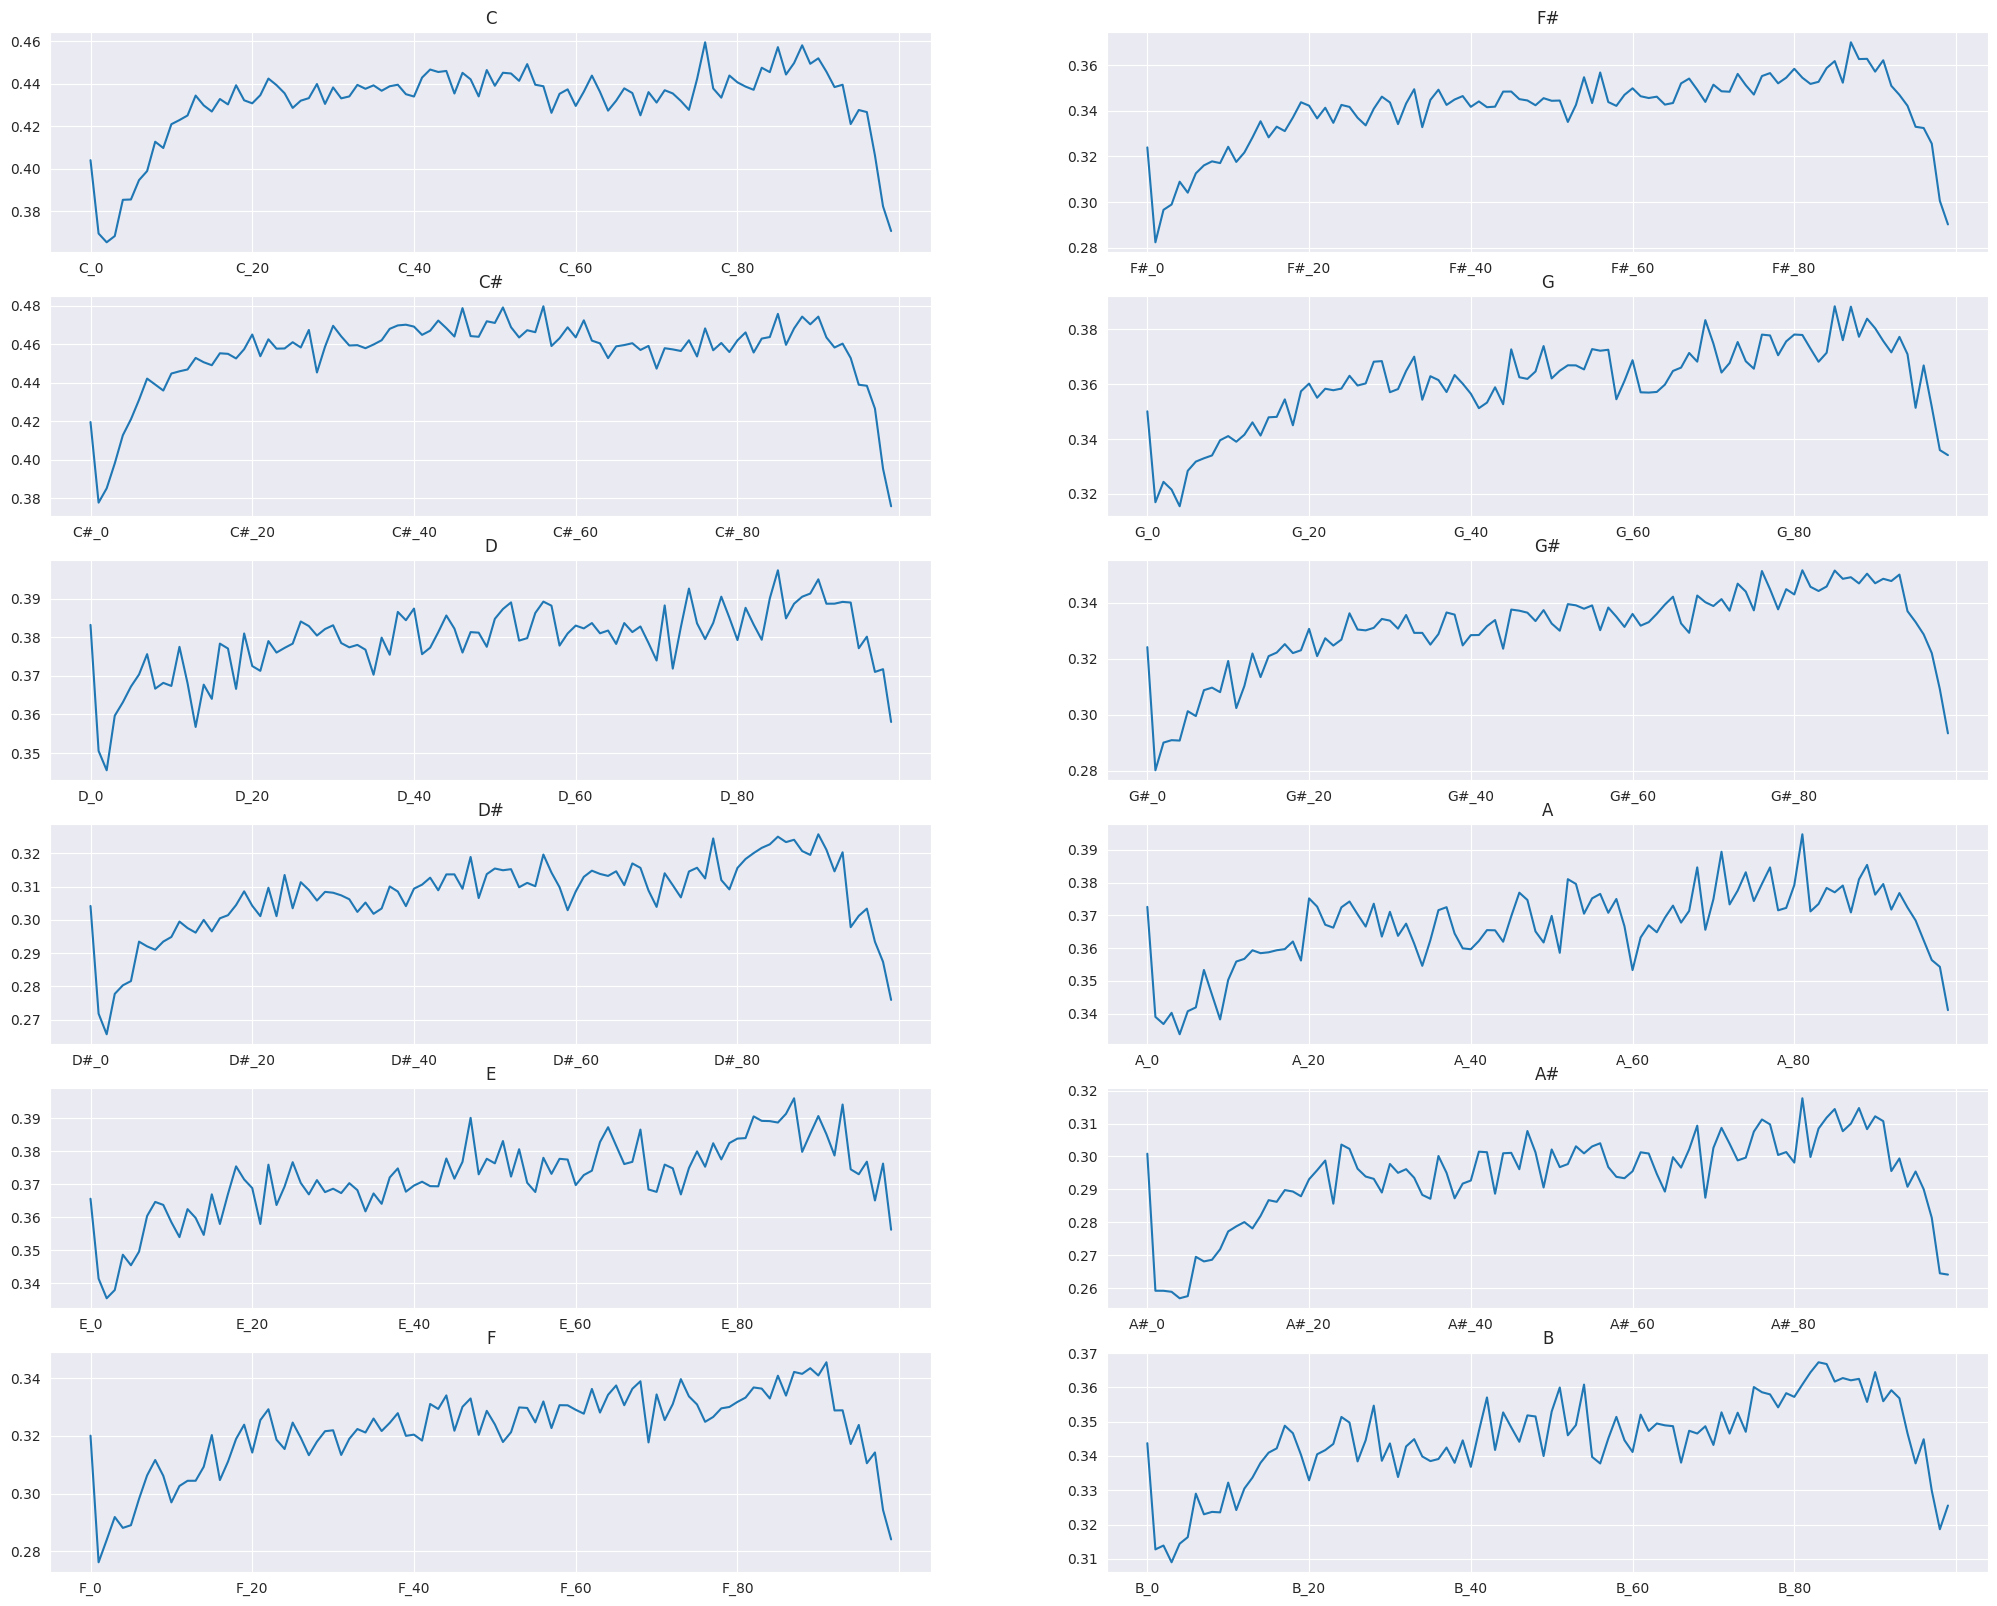

In [306]:
fig, ax = plt.subplots(len(pitch_symbol) // 2, 2, figsize=(25, 20))

for i, note in enumerate(pitch_symbol):
    cur_ax = ax[i % (len(pitch_symbol)//2)][i // (len(pitch_symbol)//2)]
    cur_ax.set_title(note)
    curr_df = rock_df[[*[note + "_" + str(i) for i in range(0, 100)]]].mean().transpose()
    curr_df.plot(ax=cur_ax, legend=False)

C


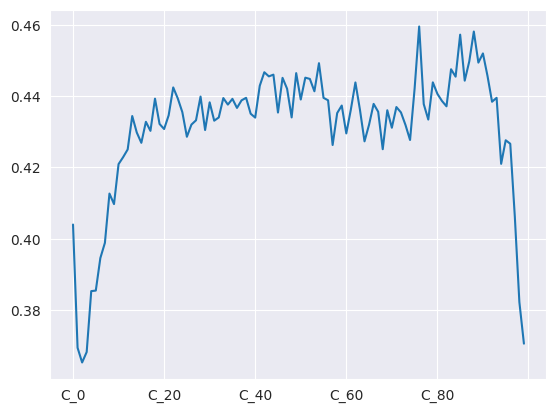

C#


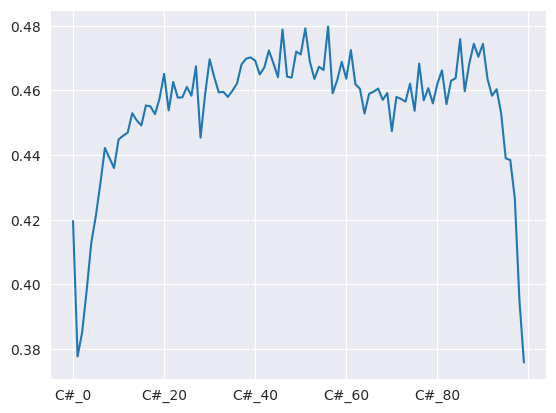

D


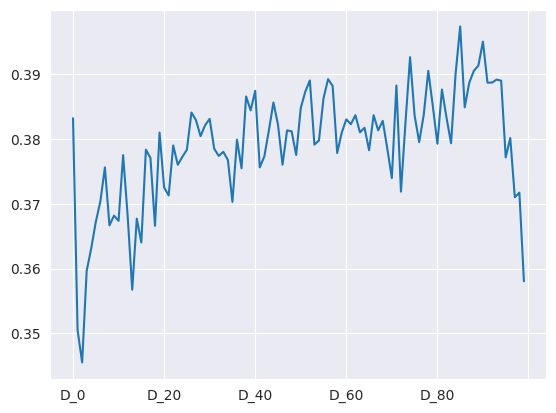

D#


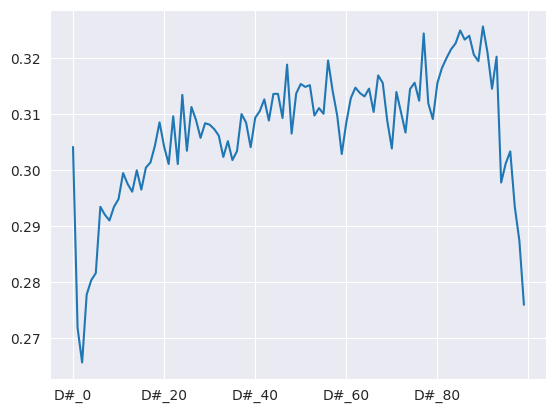

E


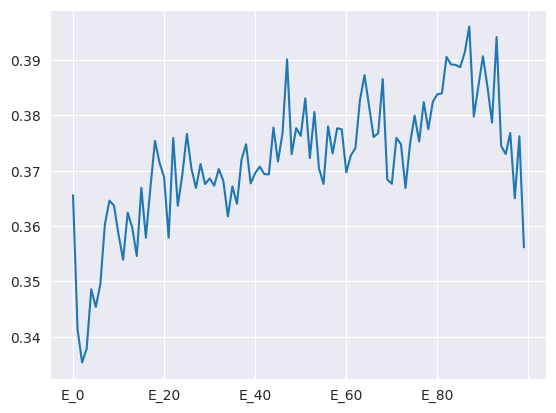

F


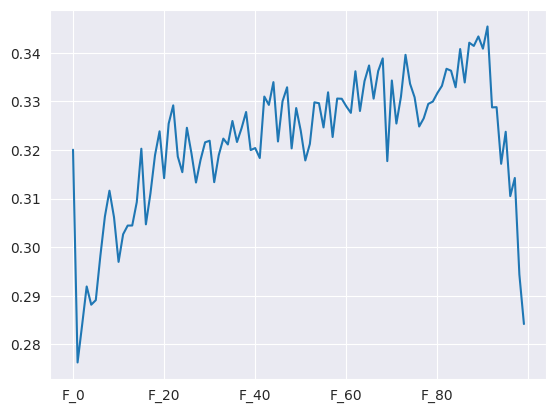

F#


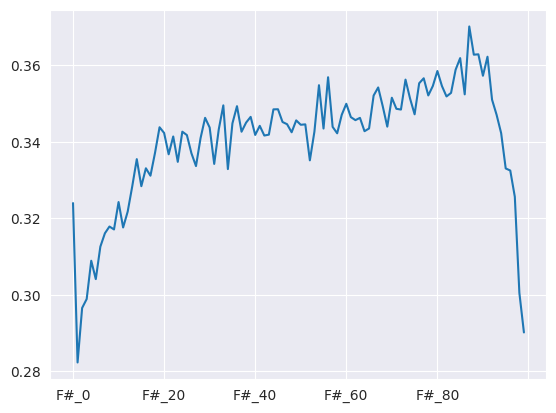

G


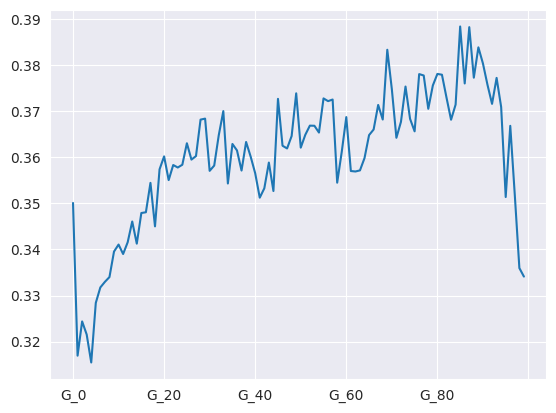

G#


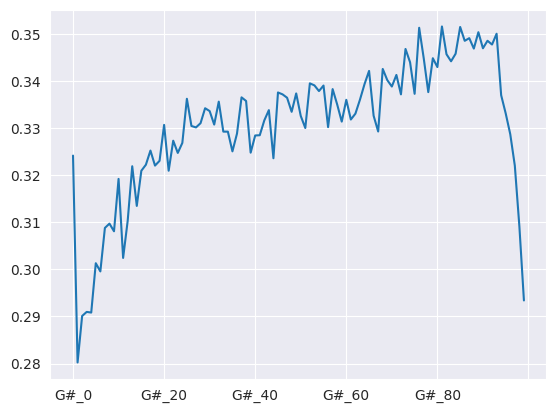

A


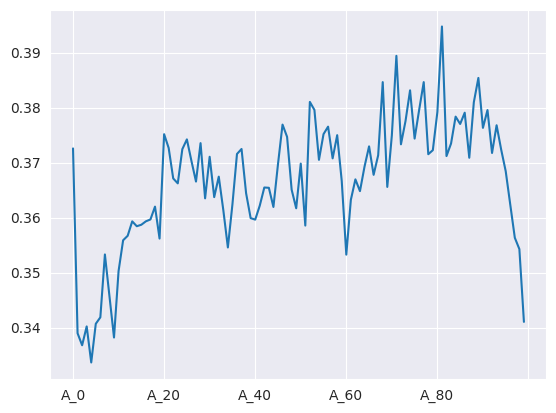

A#


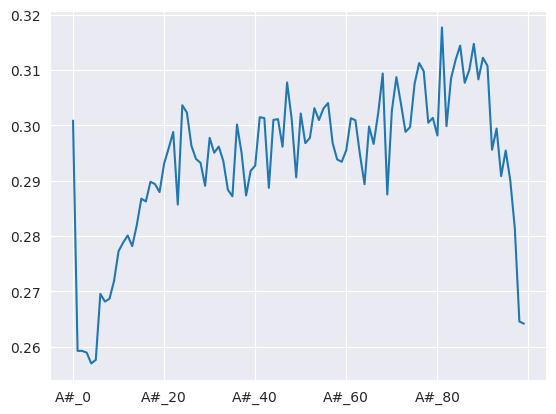

B


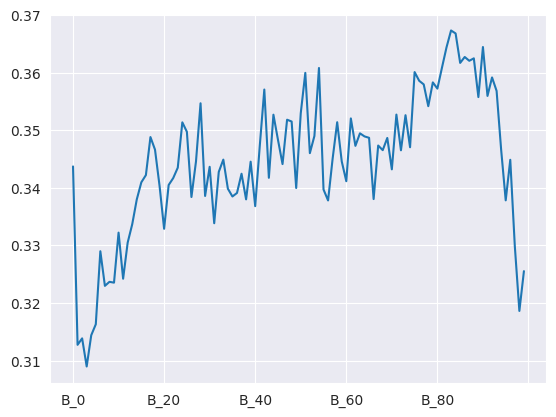

In [307]:

for note in pitch_symbol:
    print(note)
    rock_df[[*[note + "_" + str(i) for i in range(0, 100)]]].mean().transpose().plot(legend=False)
    plt.show()

# Feature Selection

In [308]:
df = df.iloc[:,1:] # drop id

In [309]:
from ast import literal_eval

df["artist_genres"] = df["artist_genres"].apply(literal_eval)
df["tags"] = df["tags"].apply(literal_eval)

In [310]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['tags'])
y = multilabel_binarizer.transform(df['tags'])

mba = MultiLabelBinarizer()
mba.fit(df['artist_genres'])
artist_genres = mba.transform(df['artist_genres'])

X = df.drop(columns=['tags', 'artist_names', 'name', "artist_genres"])
#for index, item in enumerate(artist_genres):
#    X['artist_genres'].iloc[index] = item
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)  # 70/30 split
X

,key,duration,liveness,valence,mode,danceability,tempo,loudness,energy,acousticness,...,B_90,B_91,B_92,B_93,B_94,B_95,B_96,B_97,B_98,B_99
0,5.0,179640,0.1320,0.696,1.0,0.699,129.996,-3.173,0.760,0.002230,...,0.423800,0.358250,0.325286,0.302333,0.143286,0.361429,0.526833,0.350286,0.201286,0.284500
1,9.0,284855,0.3140,0.665,1.0,0.620,167.911,-7.438,0.625,0.287000,...,0.109167,0.360357,0.459800,0.359000,0.406364,0.682875,0.467000,0.664700,0.579636,0.709000
2,1.0,180675,0.6430,0.581,0.0,0.710,80.027,-9.330,0.470,0.154000,...,0.247000,0.885750,0.278500,0.457000,0.340429,0.424167,0.507143,0.414750,0.427375,0.439667
3,0.0,204000,0.3580,0.484,1.0,0.487,149.937,-4.417,0.900,0.000068,...,0.258800,0.337375,0.378429,0.198333,0.112000,0.380600,0.701250,0.322400,0.225250,0.044500
4,0.0,248810,0.6800,0.681,1.0,0.600,77.896,-4.345,0.887,0.043800,...,0.230333,0.278400,0.158778,0.255900,0.260917,0.230545,0.284077,0.431111,0.211375,0.401667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3686,10.0,203040,0.1190,0.289,1.0,0.621,99.953,-6.941,0.417,0.288000,...,0.069200,0.366400,0.042400,0.104833,0.040333,0.056000,0.351000,0.326667,0.371333,0.741667
3687,0.0,215204,0.0881,0.428,0.0,0.730,125.960,-4.314,0.804,0.026500,...,0.479800,0.429556,0.157125,0.324200,0.493091,0.315182,0.294556,0.341444,0.535333,0.181333
3688,1.0,158800,0.5430,0.788,1.0,0.660,110.743,-9.597,0.557,0.158000,...,0.199000,0.180600,0.304800,0.248250,0.237400,0.226800,0.279500,0.292200,0.529800,0.230500
3689,2.0,212493,0.1010,0.382,1.0,0.700,110.015,-2.133,0.887,0.084300,...,0.020000,0.302250,0.032429,0.104778,0.080125,0.095800,0.158111,0.094778,0.178556,0.072333


In [311]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca

array([[ 1.16493465e+04, -4.20233712e+01, -4.01875597e+00,
         4.88862496e+00],
       [-5.12236542e+04, -1.98764471e+01,  2.27821223e+00,
         8.56615613e-01],
       [ 2.99343446e+04,  2.57248633e+01,  3.02706076e+00,
        -2.63626331e+00],
       ...,
       [-9.40186549e+04,  4.26523243e+00,  2.68922632e+00,
        -3.46040907e+00],
       [ 1.34034532e+03, -1.16023976e+00,  4.25403610e+00,
        -7.87575725e-01],
       [ 2.03293443e+04,  3.68456406e+01,  4.21024102e+00,
        -1.54502274e+00]])